In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import json
import re
from sklearn.model_selection import train_test_split


In [4]:
s3_path='s3://toxic-comment-classification-train/train.csv'
df= pd.read_csv(s3_path)

In [5]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [35]:
df_work= df.copy()

In [38]:
df_work=df_work.drop(columns=['id','severe_toxic','obscene','threat','insult','identity_hate'],axis=1)

In [39]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  159571 non-null  object
 1   toxic         159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


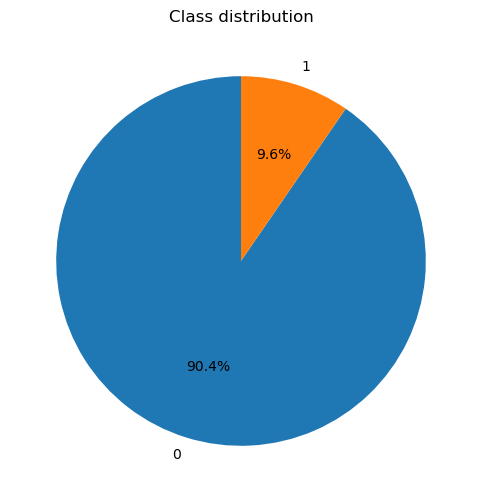

In [27]:
class_counts = df_work['toxic'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Class distribution")
plt.show()

In [15]:
counter = Counter(df['toxic'])
total = sum(counter.values())
class_weights = [total / counter[c] for c in sorted(counter.keys())]
print("\nCalculated class weights:", class_weights)



Calculated class weights: [1.1060044220492524, 10.433568719759382]


In [16]:
class_weights_tensor = torch.FloatTensor(class_weights)
print("Tensor form (for training):", class_weights_tensor)


Tensor form (for training): tensor([ 1.1060, 10.4336])


In [17]:
with open("class_weights.json", "w") as f:
    json.dump(class_weights, f)

In [18]:
def clean_text_light(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.replace("\n", " ").replace("\t", " ")
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [40]:
df_work['comment_text'] = df_work['comment_text'].apply(clean_text_light)


In [41]:
train, temp = train_test_split(df_work, test_size=0.2, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)


In [42]:
train.info(),test.info(),valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127656 entries, 140030 to 121958
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  127656 non-null  object
 1   toxic         127656 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 15958 entries, 116051 to 124631
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  15958 non-null  object
 1   toxic         15958 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 374.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 15957 entries, 66232 to 84672
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  15957 non-null  object
 1   toxic         15957 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 374.0+ KB


(None, None, None)

In [44]:
train.isna().sum(),test.isna().sum(),valid.isna().sum()

(comment_text    0
 toxic           0
 dtype: int64,
 comment_text    0
 toxic           0
 dtype: int64,
 comment_text    0
 toxic           0
 dtype: int64)

In [46]:
print(train['toxic'].unique()) 
print(valid['toxic'].unique()) 
print(test['toxic'].unique()) 


[1 0]
[0 1]
[0 1]


In [47]:
train.to_csv("train.csv", index=False)
valid.to_csv("valid.csv", index=False)
test.to_csv("test.csv", index=False)